In [ ]:
""" 
We are building a State Graph. It has two main nodes:

    The Agent: Decides if it needs to use a tool.

    The Tool Extractor: Executes the tool and feeds the result back to the agent


    tavily-python (it's free for a good amount of searches).
""";

In [56]:
import os
from typing import Annotated, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage



In [57]:
# Define the State
from langgraph.graph.message import add_messages

class State(TypedDict):
    # 'add_messages' is the glue that keeps the history alive
    messages: Annotated[list[BaseMessage], add_messages]



In [58]:
# 1. Initialize Gemini 2.5 Flash-Lite
# Note: Ensure GOOGLE_API_KEY is in your environment variables
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0,
    max_output_tokens=50  
)



In [59]:
from dotenv import load_dotenv
load_dotenv() 

True

In [ ]:
# 2. Setup Tools
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
tool_node = ToolNode(tools)

# 3. Bind tools to Gemini
# Force Gemini to use a tool
llm_with_tools = llm.bind_tools(
    tools, 
    # tool_choice="any" # This forces the model to pick a tool from your list
)

# TAVILY_API_KEY

In [67]:
# --- Graph Nodes ---

def call_model(state: State):
    response = llm_with_tools.invoke(state['messages'])
    return {"messages": [response]}

def should_continue(state: State):
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tools"
    return END



In [68]:
# --- Build the Graph ---

workflow = StateGraph(State)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

In [69]:
app = workflow.compile()

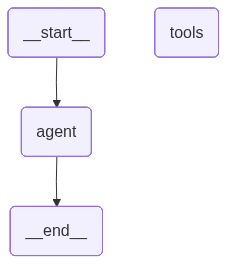

In [70]:
app

In [71]:
from langchain_core.messages import HumanMessage, SystemMessage

system_msg = SystemMessage(content=(
    "You are a helpful assistant with access to a real-time web search tool. "
    "If you don't know an answer (like the weather or current events), "
    "ALWAYS use the search tool. Do not say you cannot help; use your tools instead."
))

inputs = {
    "messages": [
        system_msg, 
        HumanMessage(content="What is the current weather in Nashik?")
    ]
}

for output in app.stream(inputs):
    print(output)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Nashik"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c3b4a-6973-7df2-8134-7e6debbd8a91-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Nashik'}, 'id': '525d145a-f085-45ad-967f-42945beb94e8', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 133, 'output_tokens': 24, 'total_tokens': 157, 'input_token_details': {'cache_read': 0}})]}}
{'tools': {'messages': [ToolMessage(content='[{"title": "Weather in Nāsik in February 2026 (State of Mahārāshtra)", "url": "https://world-weather.info/forecast/india/nashik/february-2026/", "content": "Weather in Nāsik in February 2026 (State of Mahārāshtra) - Detailed Weather Forecast for a Month\\n\\n, based on February 2026 